# On Analyzing Real World Time Series for Forecasting Stock Data
- Reference: real_world_investigation-base.ipynb

In [1]:
from collections import namedtuple
from data_loader import build_stock_uts
from ts_models import Model, AR, EvaluationMetric
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Stock Data Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data
11. Split Returns Data
12. Initialize Autoregressive AR(p) Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
15. Follow-up

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2013-01-01", "2023-10-08"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("^GSPC", "S&P 500"),
    ("AAPL", "Apple"),
    ("INTC", "Intel"),
    ("AMZN", "Amazon"),
    ("TSLA", "Tesla"),
    ("GOOGL", "Google")
]
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, start_date=start_date, end_date=end_date) for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [4]:
stock_symbol = 'AAPL'
col = 'Close'
type(stocks[stock_symbol]), stocks[stock_symbol]

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Open))

How to call the created object
- stocks['AAPL'] is our `object`
- `object` `.method`
- NOTE: Do NOT need `()` when calling methods with `@property`

In [5]:
stock_series = stocks[stock_symbol].get_series()
stock_series

array([ 19.77928543,  19.56714249,  19.17749977, ..., 171.08999634,
       173.78999329, 173.80000305])

In [6]:
stock_df = stocks[stock_symbol].get_as_df()
stock_df

Open
Date                  
2013-01-02   19.779285
2013-01-03   19.567142
2013-01-04   19.177500
2013-01-07   18.642857
2013-01-08   18.900356
...                ...
2023-10-02  171.220001
2023-10-03  172.259995
2023-10-04  171.089996
2023-10-05  173.789993
2023-10-06  173.800003

[2710 rows x 1 columns]

### Plot Raw Data

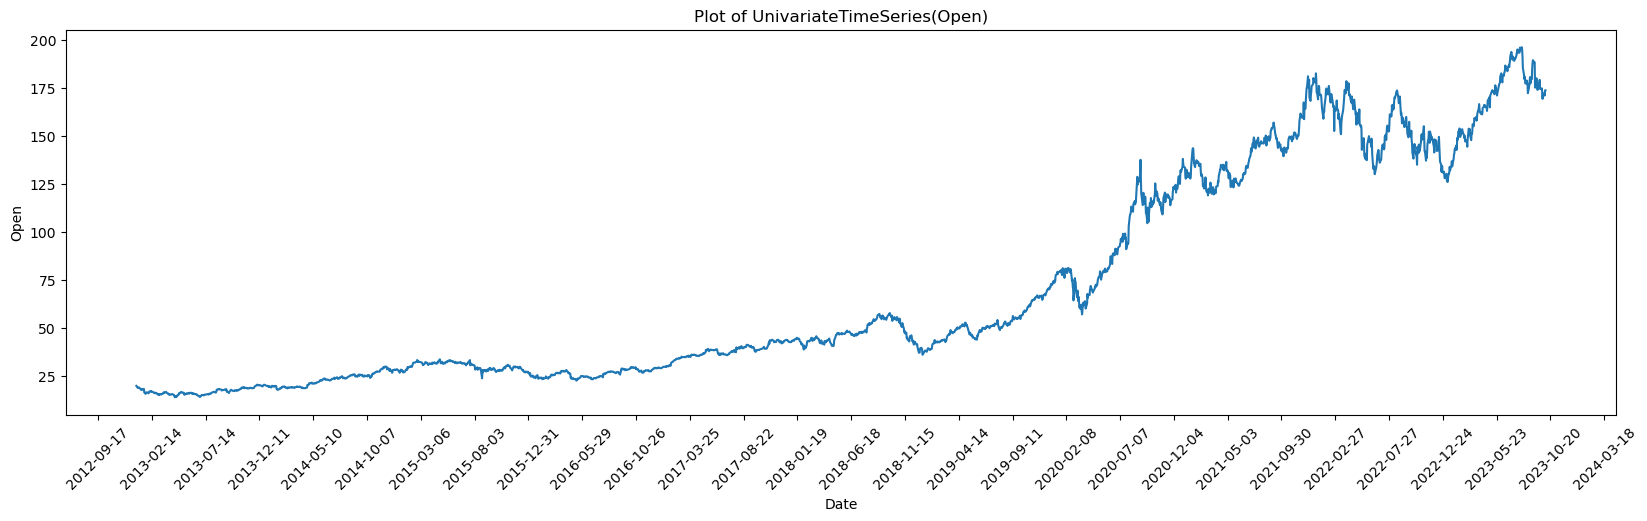

In [7]:
stocks[stock_symbol].plot(tick_skip=150)

### Get Descriptive Statistics of Raw Data

In [8]:
stocks[stock_symbol].get_statistics()

Open
count  2710.000000
mean     69.890785
std      54.436188
min      13.856071
25%      27.474374
50%      43.520000
75%     125.259998
max     196.240005

In [9]:
stocks[stock_symbol].max_min_range()

{'Max': Open    196.240005
 dtype: float64,
 'Min': Open    13.856071
 dtype: float64,
 'Range': Open    182.383934
 dtype: float64}

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary.
    - Can we verify this non-stationary with plotting the Autocorrelation?

In [10]:
stocks[stock_symbol].stationarity_test(stock_df)

Series is non-stationary as 0.9735368995834476 > 0.05


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

- Below, there seems to be a high ACor, which means there's NOT such a difference between our 1st observation and k-th lag observation
    - What to do with this?  We must take the `returns`.
- The Partial ACor dies out after 2. Why?

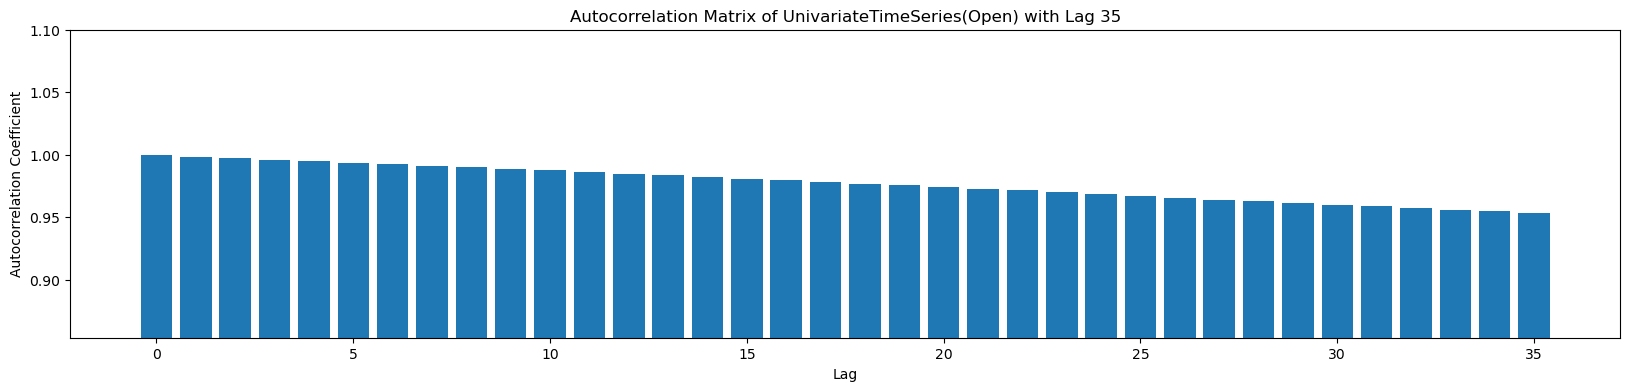

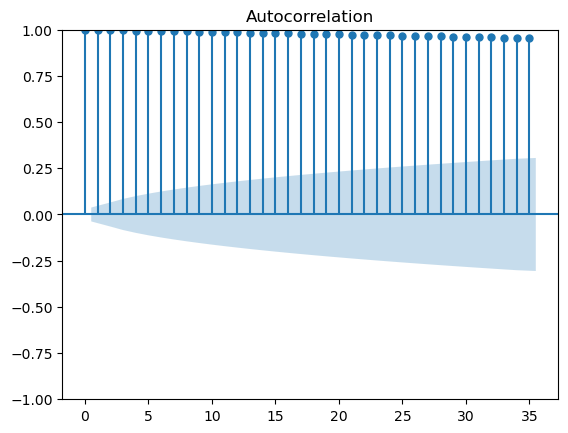

In [11]:
stocks[stock_symbol].plot_autocorrelation(35)

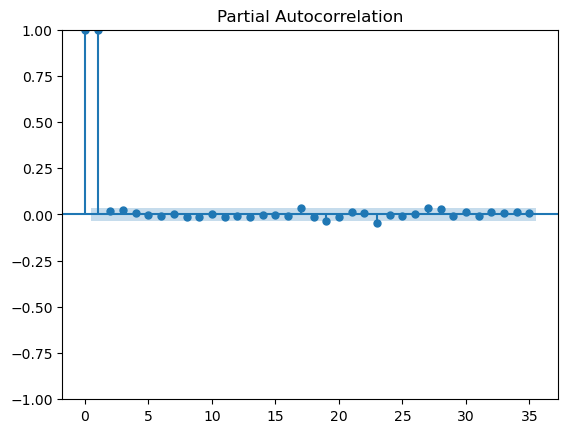

In [12]:
stocks[stock_symbol].plot_partial_autocorrelation(35)

### Get Returns Data

- Forecast returns
- Why: To have more stationarity (for the returns) compared to the prices `Open`/`Close` which is non-stationary
- Calculate with the `change` between $ z_t $ and $ z_{t-1} $
$$ Change = ((z_t - z_{t-1}) \div | z_{t-1} |) \space \rightarrow decimal \space form $$
$$ Percent \space Change = Change \times 100 \space \rightarrow pecent \space form $$
    - If `change` < 0, then stock price is going down, hence a **loss** from $ z_{t-1} \rightarrow z_t $
    - If `change` > 0, then stock price is going up, hence a **gain** from $ z_{t-1} \rightarrow z_t $
    - If `change` = 0, then stock price is constant, hence a **no loss nor no gain** from $ z_{t-1} \rightarrow z_t $
- NOTE: Shift the date by 1 because we don't have anything to subtract the 0th date by.

In [13]:
stock_returns = stocks[stock_symbol].data_augment_for_returns()
stock_returns

UnivariateTimeSeries(Returns)

In [14]:
stock_returns_df = stock_returns.get_as_df()
stock_returns_df

Returns
Date                
2013-01-03 -0.010726
2013-01-04 -0.019913
2013-01-07 -0.027879
2013-01-08  0.013812
2013-01-09 -0.012679
...              ...
2023-10-02 -0.004651
2023-10-03  0.006074
2023-10-04 -0.006792
2023-10-05  0.015781
2023-10-06  0.000058

[2709 rows x 1 columns]

### Plot Returns Data

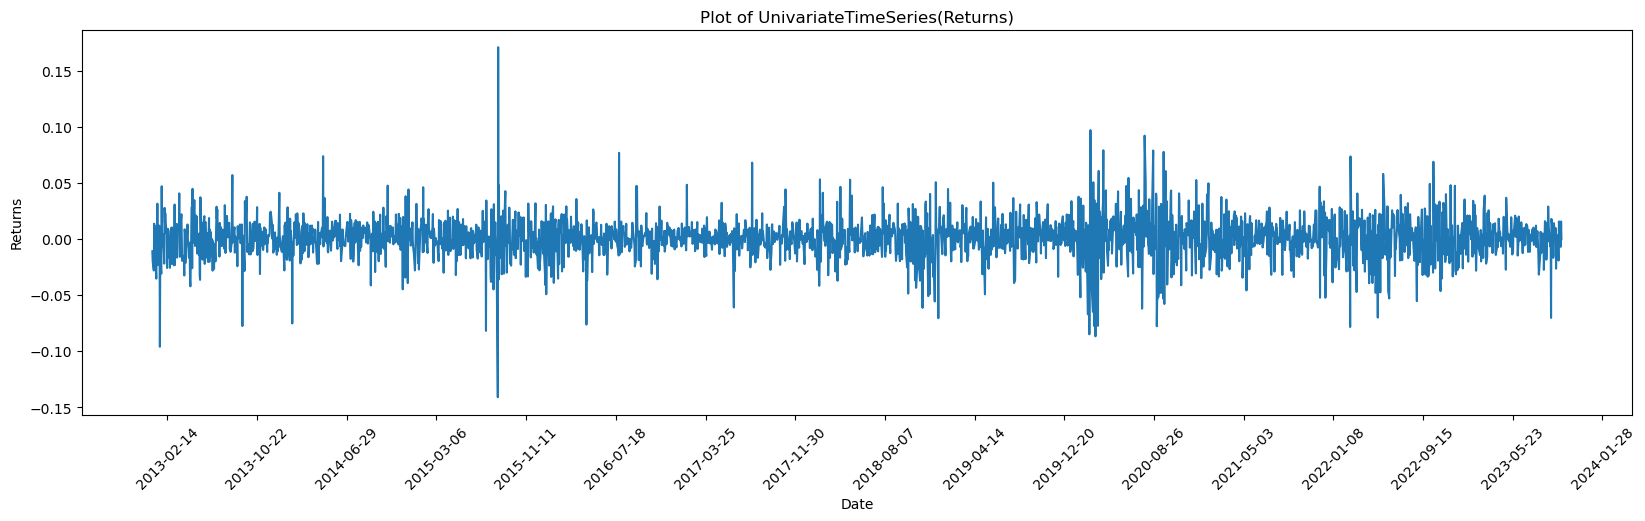

In [15]:
stock_returns.plot(tick_skip=250)

### Get Descriptive Statistics of Returns Data

In [16]:
stock_returns.get_statistics()

Returns
count  2709.000000
mean      0.000974
std       0.018528
min      -0.140904
25%      -0.007869
50%       0.001423
75%       0.010269
max       0.171182

### Check Stationarity of Returns Data

In [17]:
stock_returns.stationarity_test(stock_returns_df)

Series is stationary as 0.0 < 0.05


### Plot Autocorrelation and Partial Autocorrelation of Returns Data

- Below, the ACor between our 1st observation and k-th lag observation is low. This ACor resembles the Raw Data Partial ACor plot. Why?
- The Partial ACor is similar (to the Raw Data Partial ACor plo), except it here, it dies out at 2 (compared to the Raw Data Partial ACor plot which dies out after 2). Why?

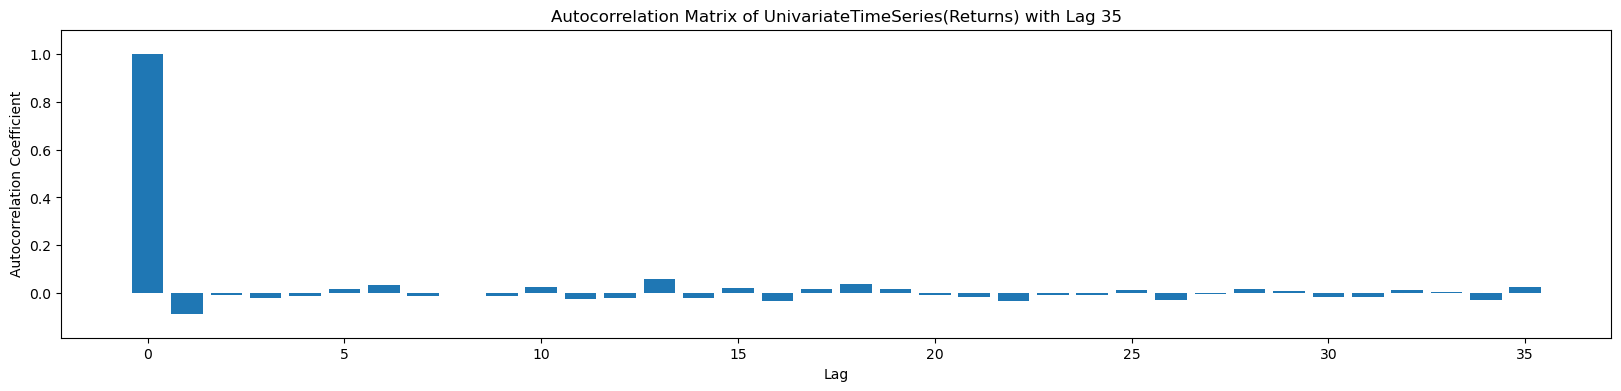

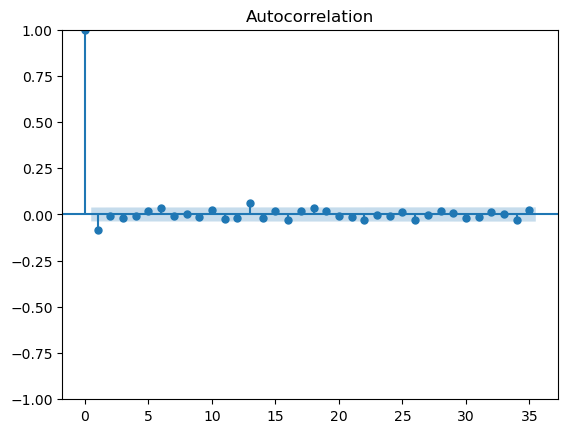

In [18]:
stock_returns.plot_autocorrelation(35)

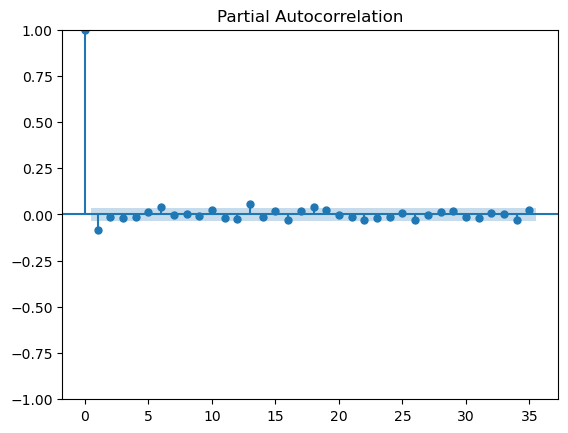

In [19]:
stock_returns.plot_partial_autocorrelation(35)

### Split Returns Data

- Splitting so we can forecast the last 7 days. Do this type of forecast to see how model is performing. If model performs how we need, then update notebook to forecast the next 7 days.

In [20]:
stock_returns_len = len(stock_returns_df)
stock_returns_len

2709

In [21]:
get_train_len = len(stock_returns_df[:2700])
get_train_len

2700

In [22]:
get_train_percentage = float(get_train_len / stock_returns_len)
get_train_percentage

0.9966777408637874

In [23]:
train, validation, test = stock_returns.get_train_validation_test_split(get_train_percentage, 0.0)

0 2700
2700 2700
2700 2709


In [24]:
train

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[0:2700])

In [25]:
train.get_as_df()

UnivariateTimeSeries(Returns)[0:2700]
Date                                             
2013-01-03                              -0.010726
2013-01-04                              -0.019913
2013-01-07                              -0.027879
2013-01-08                               0.013812
2013-01-09                              -0.012679
...                                           ...
2023-09-19                               0.005893
2023-09-20                               0.009802
2023-09-21                              -0.026275
2023-09-22                               0.000687
2023-09-25                              -0.002691

[2700 rows x 1 columns]

In [26]:
validation

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[2700:2700])

In [27]:
validation.get_as_df()

Empty DataFrame
Columns: [UnivariateTimeSeries(Returns)[2700:2700]]
Index: []

In [28]:
test

UnivariateTimeSeries(UnivariateTimeSeries(Returns)[2700:2709])

In [29]:
test.get_as_df()

UnivariateTimeSeries(Returns)[2700:2709]
Date                                                
2023-09-26                                  0.003559
2023-09-27                                 -0.012584
2023-09-28                                 -0.019001
2023-09-29                                  0.015826
2023-10-02                                 -0.004651
2023-10-03                                  0.006074
2023-10-04                                 -0.006792
2023-10-05                                  0.015781
2023-10-06                                  0.000058

In [30]:
expected_forecast = test.get_series()
expected_forecast

array([ 3.55918707e-03, -1.25844418e-02, -1.90012679e-02,  1.58261958e-02,
       -4.65063965e-03,  6.07401751e-03, -6.79204810e-03,  1.57811503e-02,
        5.75969044e-05])

### Initialize Autoregressive AR(p) Model

- How to determine the proper lag value? Look at the Partial ACor plot. Being that we're out of the blue area at lag 3, we'll set our lag to be 3.
    - Why Partial ACor plot and not ACor plot?
    - What if we take lags from ACor plot anyway? Say lags 5, 10, and 15 because they all have the most correlation (postive and negative) for their clusters, respectfully.
- How to understand the model summary?

In [31]:
positive_pacor = [6, 12, 17]
negative_pacor = [2, 16, 22, 33]
lags_to_test = positive_pacor + negative_pacor
lags_to_test = sorted(lags_to_test)
lags_to_test

[2, 6, 12, 16, 17, 22, 33]

In [32]:
# create an object from the AR() class
ar_model_class = AR()

# call the function to train our AR model
trained_ar_models = ar_model_class.train_ar_model(train.get_series(), lags_to_test)

Model 1 with a lag of 2
Model 2 with a lag of 6
Model 3 with a lag of 12
Model 4 with a lag of 16
Model 5 with a lag of 17
Model 6 with a lag of 22
Model 7 with a lag of 33


In [33]:
len_historical_data, historical_data = train.get_historical_data()
len_historical_data

2700

### Predict Forecasts of Retruns Data

In [34]:
predictions = ar_model_class.predict(trained_ar_models, len_historical_data, train, test)
predictions

Model 1 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x19ff27b80>
Model 2 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x19ff15430>
Model 3 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a0013ac0>
Model 4 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x1a0006d60>
Model 5 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x19fedcf10>
Model 6 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x19fe9b4c0>
Model 7 <statsmodels.tsa.ar_model.AutoRegResultsWrapper object at 0x19fe4e760>


[array([0.00131387, 0.00102124, 0.00098177, 0.00098993, 0.00098986,
        0.00098974, 0.00098975, 0.00098975, 0.00098975]),
 array([ 1.84858456e-03,  1.70552179e-03,  8.50551191e-04, -5.15001749e-05,
         9.87763299e-04,  8.83153005e-04,  1.08004930e-03,  1.03277475e-03,
         9.71891672e-04]),
 array([1.17542634e-03, 1.47750191e-03, 9.93004999e-04, 1.02409582e-03,
        1.09480457e-03, 5.12166301e-04, 1.43319970e-03, 9.17303920e-05,
        1.51394020e-03]),
 array([-2.98631620e-03,  3.88709134e-03,  7.14874684e-05,  2.84722756e-03,
        -1.18294330e-04, -2.13191092e-04,  2.24014514e-03,  2.45857855e-04,
         2.35719913e-03]),
 array([-2.74981253e-03,  4.14197681e-03, -9.47379189e-06,  2.73876950e-03,
        -1.28182614e-03,  1.81136837e-04,  2.47036991e-03,  1.94307670e-04,
         2.05897077e-03]),
 array([-1.70946455e-03,  5.49773453e-03, -6.26162774e-05,  1.93430279e-03,
        -2.59535936e-03, -3.16339447e-03,  1.86270627e-03,  1.15845274e-03,
         3.0237

In [35]:
mse_gsts = EvaluationMetric.eval_mse(expected_forecast, predictions)
mse_gsts

expected [ 3.55918707e-03 -1.25844418e-02 -1.90012679e-02  1.58261958e-02
 -4.65063965e-03  6.07401751e-03 -6.79204810e-03  1.57811503e-02
  5.75969044e-05] predicted [0.00131387 0.00102124 0.00098177 0.00098993 0.00098986 0.00098974
 0.00098975 0.00098975 0.00098975] mse 0.01129143521387688
expected [ 3.55918707e-03 -1.25844418e-02 -1.90012679e-02  1.58261958e-02
 -4.65063965e-03  6.07401751e-03 -6.79204810e-03  1.57811503e-02
  5.75969044e-05] predicted [ 1.84858456e-03  1.70552179e-03  8.50551191e-04 -5.15001749e-05
  9.87763299e-04  8.83153005e-04  1.08004930e-03  1.03277475e-03
  9.71891672e-04] mse 0.011510296202680806
expected [ 3.55918707e-03 -1.25844418e-02 -1.90012679e-02  1.58261958e-02
 -4.65063965e-03  6.07401751e-03 -6.79204810e-03  1.57811503e-02
  5.75969044e-05] predicted [1.17542634e-03 1.47750191e-03 9.93004999e-04 1.02409582e-03
 1.09480457e-03 5.12166301e-04 1.43319970e-03 9.17303920e-05
 1.51394020e-03] mse 0.011557448497380583
expected [ 3.55918707e-03 -1.2584441

### Plot Actual Forecasts vs Predicted Forecasts for Returns Data

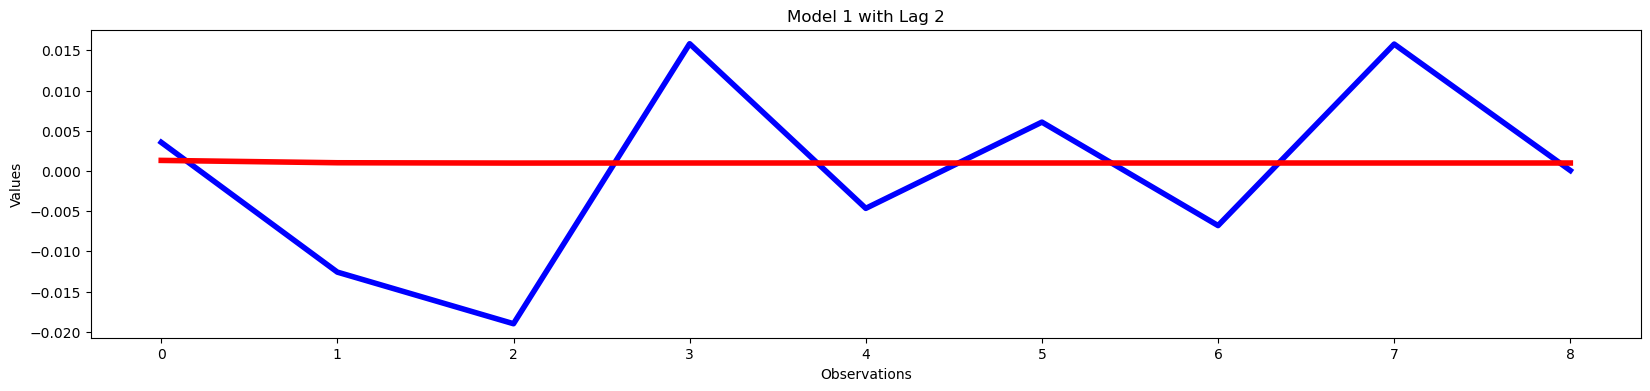

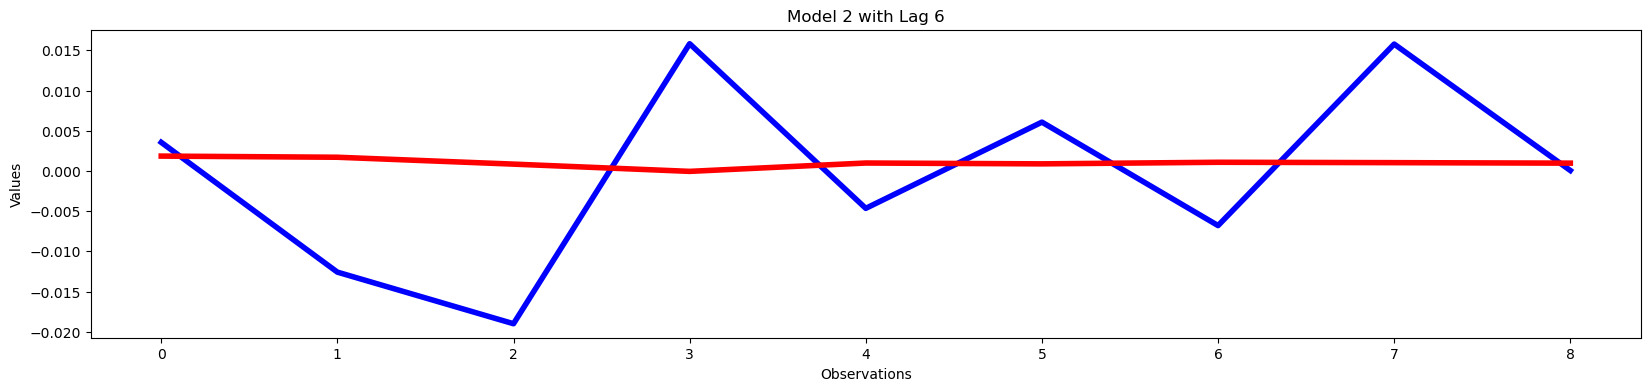

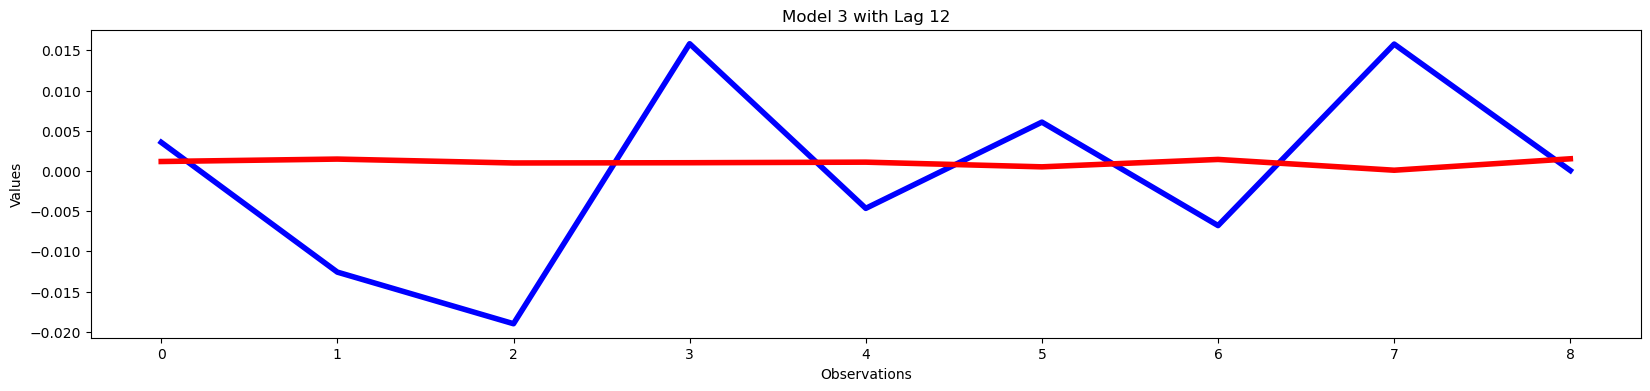

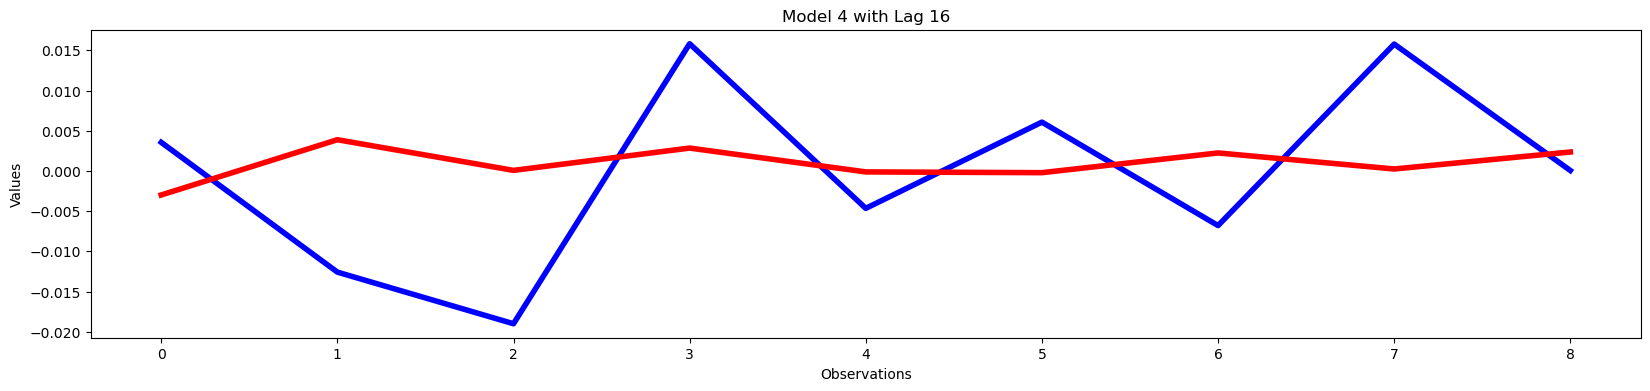

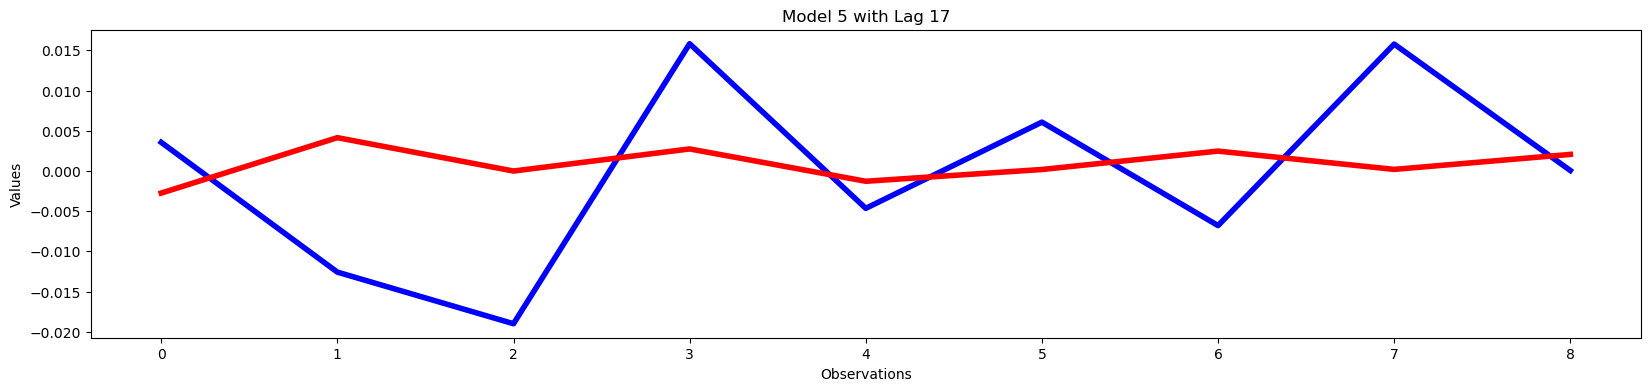

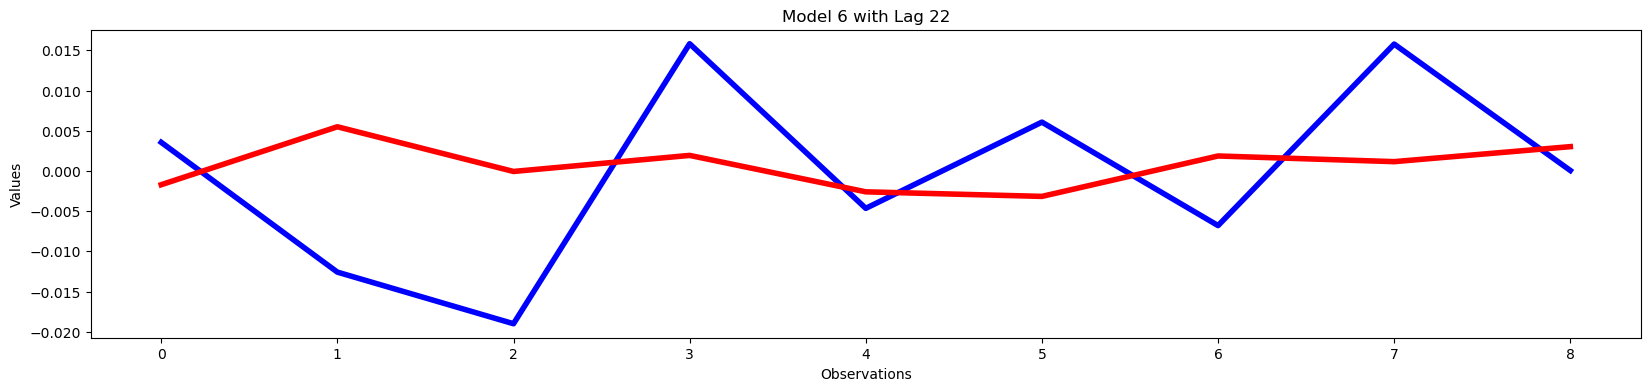

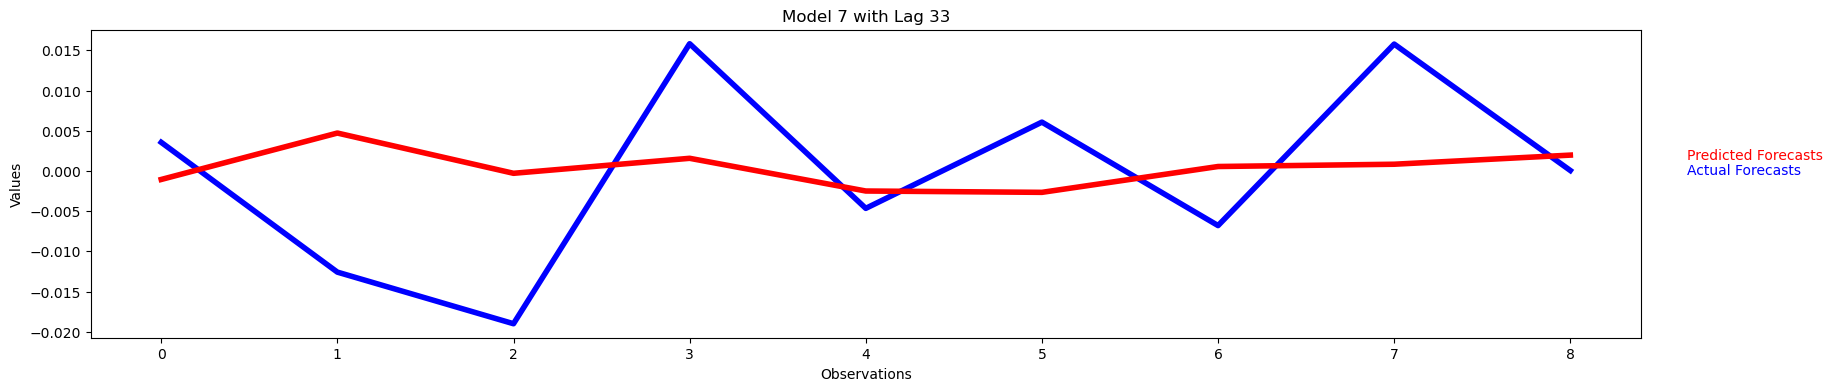

In [36]:
EvaluationMetric.plot_forecast(expected_forecast, predictions, lags_to_test)

### Follow-up
- What can we determine from this?
    - None of the models with the specified lag are performing well. Why?
- Which AR(p) lag performs the best?
    - Difficult to state. 
- Can we do better?
    - We must lol!